In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"
plt.rc('font', family="serif")
plt.rc('font', size=22)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']


In [3]:
from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap
import os
import h5py


In [4]:
from diffstar.utils import _get_dt_array
from diffstar.fit_smah_helpers import get_header, load_diffstar_data
from diffstar.stars import (
    calculate_sm_sfr_fstar_history_from_mah,
    compute_fstar,
    compute_fstar_vmap,
    _sfr_eff_plaw,
    TODAY,
    _get_bounded_sfr_params, 
    _get_unbounded_sfr_params,
    calculate_histories,
    calculate_histories_vmap,
    calculate_histories_batch,
    fstar_tools,
)

from diffstar.quenching import _get_bounded_q_params, _get_unbounded_q_params
from diffmah.individual_halo_assembly import _calc_halo_history


def calculate_fstar_data_batch(tarr, sm_cumsum, index_select, index_high, fstar_tdelay):
    ng = len(sm_cumsum)
    nt = len(index_high)
    fstar = np.zeros((ng,nt))
    indices = np.array_split(np.arange(ng), int(ng/5000))
    for inds in indices:
        fstar[inds] = compute_fstar_vmap(tarr, sm_cumsum[inds], index_select, index_high, fstar_tdelay)
    return fstar
    
def _calculate_sm(lgt, dt, mah_params, sfr_params, q_params, index_select, index_high, fstar_tdelay):
    dmhdt, log_mah = _calc_halo_history(lgt, *mah_params)
    mstar, sfr, fstar = calculate_sm_sfr_fstar_history_from_mah(
        lgt, dt, dmhdt, log_mah, sfr_params, q_params,
        index_select,
        index_high,
        fstar_tdelay
    )
    return mstar, sfr, fstar, dmhdt, log_mah



calculate_sm = jjit(vmap(_calculate_sm, in_axes=(None, None, 0, 0, 0, None, None, None)))



/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


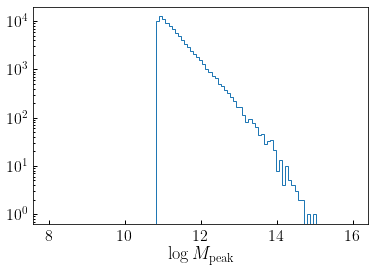

In [5]:
from astropy.cosmology import Planck15



data_path = "/Users/alarcon/Documents/diffmah_data/"
results_path = data_path

halos_SMDPL = np.load(data_path+'SMDPL_subvol0..9.npz')
SMDPL_a = np.load(data_path+"scale_list_SMDPL.npy")
SMDPL_z = 1.0 / SMDPL_a - 1.0
SMDPL_t = Planck15.age(SMDPL_z).value

dt_SMDPL = _get_dt_array(SMDPL_t)

H_SMDPL = 0.6777
# From https://www.cosmosim.org/cms/simulations/smdpl/
# The mass particle resolution is 9.63e7 Msun/h
particle_mass_res = 9.63e7 / H_SMDPL
# So we cut halos with M0 below 500 times the mass resolution.
logmpeak_fit_min = np.log10(500 * particle_mass_res)

sm_cumsum_SMDPL = np.cumsum(halos_SMDPL['sfr_history_main_prog']*dt_SMDPL,axis=1)*1e9
mhalo_SMDPL = np.maximum.accumulate(halos_SMDPL["mpeak_history_main_prog"], axis=1)
logmpeak_SMDPL = np.log10(mhalo_SMDPL[:, -1])
sfrh_SMDPL = halos_SMDPL['sfr_history_main_prog']
sSFR_SMDPL = halos_SMDPL["sfr_history_main_prog"] / sm_cumsum_SMDPL

sel = logmpeak_SMDPL >= logmpeak_fit_min

sm_cumsum_SMDPL = sm_cumsum_SMDPL[sel]
mhalo_SMDPL = mhalo_SMDPL[sel]
logmpeak_SMDPL = logmpeak_SMDPL[sel]
sfrh_SMDPL = sfrh_SMDPL[sel]
sSFR_SMDPL = sSFR_SMDPL[sel]


_bins = np.linspace(8,16,100)
plt.hist(logmpeak_SMDPL, bins=_bins, histtype='step')
plt.xlabel(r'$\log M_{\rm{peak}}$')
plt.yscale('log')
plt.show()


def get_mah_params(runname1):
    
    fitting_data = dict()

    fn = f"{data_path}{runname1}"
    with h5py.File(fn, 'r') as hdf:
        for key in hdf.keys():
            if key == 'halo_id':
                fitting_data[key] = hdf[key][...]
            else:
                fitting_data['fit_'+key] = hdf[key][...]
                
    mah_params = np.array([
        np.log10(fitting_data['fit_t0']),
        fitting_data['fit_logmp_fit'],
        fitting_data['fit_mah_logtc'],
        fitting_data['fit_mah_k'],
        fitting_data['fit_early_index'],
        fitting_data['fit_late_index'], 
    ]).T
    return mah_params
            
            
mah_params_SMDPL_arr = []  
for i in range(10):
    runname1 = "run1_SMDPL_diffmah_default_%d.h5"%i
    mah_params_SMDPL_arr.append(get_mah_params(runname1))
    
mah_params_SMDPL = np.concatenate(mah_params_SMDPL_arr, axis=0)

            
            
fstar_tdelay = 1.0
index_select_SMDPL, fstar_indx_high_SMDPL = fstar_tools(SMDPL_t, fstar_tdelay)

lgt_SMDPL = np.log10(SMDPL_t)


fstar_data_SMDPL = calculate_fstar_data_batch(SMDPL_t, sm_cumsum_SMDPL, index_select_SMDPL, fstar_indx_high_SMDPL, fstar_tdelay)

In [6]:
def get_multiple_diffstar_res():
    mstar_arr = []
    sfr_arr = []
    fstar_arr = []
    dmhdt_arr = []
    log_mah_arr = []
    fit_params_arr = []
    u_fit_params_arr = []
    loss_arr = []
    success_arr = []

    _res_SMDPL = []
    for i in range(10):
        runname1 = "run1_SMDPL_diffstar_default_%i.h5"%i
        _res_SMDPL = load_diffstar_data(runname1, SMDPL_t, fstar_tdelay, mah_params_SMDPL_arr[i], results_path)

        mstar_arr.append(_res_SMDPL[0][0])
        sfr_arr.append(_res_SMDPL[0][1])
        fstar_arr.append(_res_SMDPL[0][2])
        dmhdt_arr.append(_res_SMDPL[0][3])
        log_mah_arr.append(_res_SMDPL[0][4])
        fit_params_arr.append(_res_SMDPL[1])
        u_fit_params_arr.append(_res_SMDPL[2])
        loss_arr.append(_res_SMDPL[3])
        success_arr.append(_res_SMDPL[4])

    mstar_arr = np.concatenate(mstar_arr, axis=0)
    sfr_arr = np.concatenate(sfr_arr, axis=0)
    fstar_arr = np.concatenate(fstar_arr, axis=0)
    dmhdt_arr = np.concatenate(dmhdt_arr, axis=0)
    log_mah_arr = np.concatenate(log_mah_arr, axis=0)
    fit_params_arr = np.concatenate(fit_params_arr, axis=0)
    u_fit_params_arr = np.concatenate(u_fit_params_arr, axis=0)
    loss_arr = np.concatenate(loss_arr, axis=0)
    success_arr = np.concatenate(success_arr, axis=0)

    res = (
        (
            mstar_arr,
            sfr_arr,
            fstar_arr,
            dmhdt_arr,
            log_mah_arr,
        ),
        fit_params_arr,
        u_fit_params_arr,
        loss_arr,
        success_arr
    )

    return res

res_SMDPL = get_multiple_diffstar_res()

(9498, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([  10, 9488]))
(9092, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   5, 9087]))
(9081, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   8, 9073]))
(9242, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   5, 9237]))
(9333, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   5, 9328]))
(9408, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   4, 9404]))
(9217, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   2, 9215]))
(9179, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   6, 9173]))
(9652, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([  14, 9638]))
(9657, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([  14, 9643]))


In [7]:
sfh_params = res_SMDPL[1]

In [8]:
from diffstarpop.pdf_quenched import DEFAULT_SFH_PDF_QUENCH_PARAMS, get_smah_means_and_covs_quench

In [9]:
from diffstar.stars import (
    calculate_sm_sfr_fstar_history_from_mah,
    DEFAULT_SFR_PARAMS as DEFAULT_SFR_PARAMS_DICT,
    _get_unbounded_sfr_params,
    TODAY,
    fstar_tools
)


In [10]:
from diffstarpop.monte_carlo_halo_population import mc_sfh_population


In [11]:
t_table = np.linspace(1.0,TODAY, 100)
fstar_tdelay = 1.0
index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)

logm0_binmids = np.linspace(11.5, 13.5, 3)
logm0_bin_widths = np.ones_like(logm0_binmids) * 0.1

sm_loss_weight = jnp.where(t_table>2.0, 1.0, 1e10)
fstar_loss_MS_weight = jnp.where(t_table[index_select]>2.0, 1.0, 1e10)
fstar_loss_Q_weight = jnp.where(t_table[index_select]>5.0, 1.0, 1e10)

sm_loss_sel = np.arange(len(t_table))[t_table>1.0]
fstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>2.0]
fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>5.0]
"""
sm_loss_sel = np.arange(len(t_table))[t_table>0.0]
fstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>0.0]
fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>0.0]
"""


'\nsm_loss_sel = np.arange(len(t_table))[t_table>0.0]\nfstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>0.0]\nfstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>0.0]\n'

In [12]:
from diffmah.monte_carlo_halo_population import mc_halo_population
N = 10
logmpeak_diffmahpop = []
mah_params_diffmahpop = []
for binmid in logm0_binmids:
    _res = mc_halo_population(t_table, TODAY, binmid * np.ones(N))
    _mahparams = np.array([
        np.ones(N)*np.log10(TODAY),
        binmid * np.ones(N),
        _res[4],
        np.ones(N)*3.5,
        _res[2],
        _res[3],
    ]).T
    
    logmpeak_diffmahpop.append(binmid * np.ones(N))
    mah_params_diffmahpop.append(_mahparams)

logmpeak_diffmahpop = np.concatenate(logmpeak_diffmahpop)
mah_params_diffmahpop = np.concatenate(mah_params_diffmahpop)

In [13]:
logm0_binmids

array([11.5, 12.5, 13.5])

In [14]:
def _get_MC_validation_quantities(N_mc_halos):

    
    mstar_MC = np.zeros((len(logm0_binmids), N_mc_halos, len(t_table)))
    sfr_MC = np.zeros((len(logm0_binmids), N_mc_halos, len(t_table)))
    fstar_MC = np.zeros((len(logm0_binmids), N_mc_halos, len(index_select)))

    _halo_sub_mask_indices = []

    for i in range(len(logm0_binmids)):
        #mask = (logmpeak_SMDPL>logm0_binmids[i]-logm0_bin_widths[i]) & (logmpeak_SMDPL<logm0_binmids[i]+logm0_bin_widths[i]) 
        #mask &= (sfh_params[:,5] < np.log10(TODAY))
        #mask = np.arange(len(logmpeak_SMDPL))[mask]#[:50]
        
        mask = (logmpeak_diffmahpop>logm0_binmids[i]-logm0_bin_widths[i]) & (logmpeak_diffmahpop<logm0_binmids[i]+logm0_bin_widths[i]) 
        mask = np.arange(len(logmpeak_diffmahpop))[np.array(mask)]#[:50]        
        
        _halo_sub_mask_indices.append(mask)

        _res = mc_sfh_population(
            jnp.log10(t_table),
            _get_dt_array(t_table),
            jnp.array([logm0_binmids[i]]),
            # mah_params_SMDPL[mask],
            mah_params_diffmahpop[mask],
            N_mc_halos,
            index_select,
            index_high,
            fstar_tdelay,
            seed=0,
            pdf_parameters=DEFAULT_SFH_PDF_QUENCH_PARAMS
        )
        mstar_MC[i] = _res[0]
        sfr_MC[i] = _res[1]
        fstar_MC[i] = _res[2]

    sFstar = fstar_MC / mstar_MC[:, :, index_select]

    _halo_sub_mask_indices = np.concatenate(_halo_sub_mask_indices)
    _halo_sub_mask_indices.shape
    
    _MC_res = []
    _MC_res.append( np.nanmean(np.log10(mstar_MC), axis=1) )
    _MC_res.append( np.nanstd(np.log10(mstar_MC), axis=1)**2 )

    _dum = fstar_MC.copy()
    _dum[(sFstar<1e-11)] = np.nan
    _MC_res.append( np.nanmean(np.log10(_dum), axis=1) )

    _dum = fstar_MC.copy()
    _dum[(sFstar>1e-11)] = np.nan
    _MC_res.append( np.nanmean(np.log10(_dum), axis=1) )

    _dum = fstar_MC.copy()
    _dum[(sFstar<1e-11)] = np.nan
    _MC_res.append( np.nanstd(np.log10(_dum), axis=1)**2 )

    _dum = fstar_MC.copy()
    _dum[(sFstar>1e-11)] = np.nan
    _MC_res.append( np.nanstd(np.log10(_dum), axis=1)**2 )


    _dum = np.sum(sFstar<1e-11,axis=1) / (np.sum(sFstar<1e-11,axis=1) + np.sum(sFstar>1e-11,axis=1))

    _MC_res.append( _dum )


    sm_mean_MC, sm_var_MC = _MC_res[0:2]
    fstar_mean_MS_MC, fstar_mean_Q_MC = _MC_res[2:4]
    fstar_var_MS_MC, fstar_var_Q_MC = _MC_res[4:6]
    quench_frac_MC = _MC_res[6]
    
    return _MC_res, _halo_sub_mask_indices, mstar_MC, sfr_MC

_MC_res, _halo_sub_mask_indices, mstar_MC, sfr_MC = _get_MC_validation_quantities(10000)




/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [15]:
import time
from diffstarpop.pdfmodel import _get_default_pdf_SFH_prediction_quench
import jax.random as jax_ran

In [16]:
init_params = np.array(list(DEFAULT_SFH_PDF_QUENCH_PARAMS.values()))
init_params

array([ 1.206e+01,  1.270e+00, -8.100e-01,  1.780e+00,  1.175e+01,
        1.232e+01,  9.600e-01, -6.300e-01, -2.230e+00,  2.480e+00,
        2.320e+01, -2.189e+01,  1.670e+00, -1.000e-02, -3.610e+00,
        4.130e+00,  3.300e-01, -5.130e+00,  1.240e+00, -3.410e+00,
       -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00,
       -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00,
       -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00,
       -1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e

In [17]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = 10000

In [18]:
# halo_data_validation = mah_params_SMDPL[:, np.array([1,2,4,5])].T.copy()
halo_data_validation = mah_params_diffmahpop[:, np.array([1,2,4,5])].T.copy()
halo_data_validation[1] = 10**halo_data_validation[1]


t0 = time.time()
_target_res = _get_default_pdf_SFH_prediction_quench(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    init_params
)

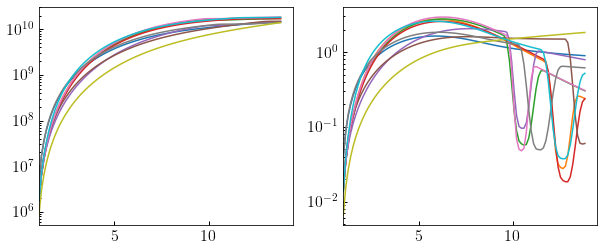

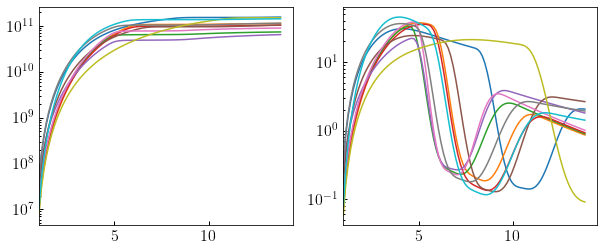

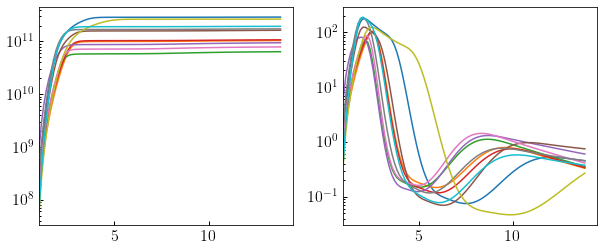

IndexError: index 3 is out of bounds for axis 0 with size 3

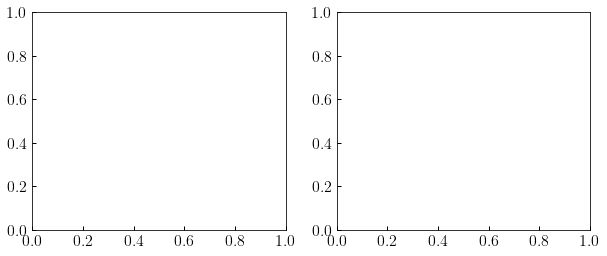

In [19]:
mstar_MC.shape

for b in range(4):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    for i in range(10):
        
        
        ax[0].plot(t_table, mstar_MC[b,i])
        ax[1].plot(t_table, sfr_MC[b,i])
        
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[0].set_xlim(1.0,None)
    ax[1].set_xlim(1.0,None)
    plt.show()

In [20]:
mstar_data_Q = np.zeros((len(logm0_binmids), len(SMDPL_t)))
mstar_data_MS = np.zeros((len(logm0_binmids), len(SMDPL_t)))

for i in range(len(logm0_binmids)):
    mask = (logmpeak_SMDPL>logm0_binmids[i]-logm0_bin_widths[i]) & (logmpeak_SMDPL<logm0_binmids[i]+logm0_bin_widths[i]) 
    mask1 = mask&(sfh_params[:,5] < np.log10(TODAY))
    mask2 = mask&(sfh_params[:,5] > np.log10(TODAY))
    
    _dum = np.where(sm_cumsum_SMDPL[mask1] > 0.0, np.log10(sm_cumsum_SMDPL[mask1]), np.nan)
    mstar_data_Q[i] = np.nanmean(_dum, axis=0)
    _dum = np.where(sm_cumsum_SMDPL[mask2] > 0.0, np.log10(sm_cumsum_SMDPL[mask2]), np.nan)
    mstar_data_MS[i] = np.nanmean(_dum, axis=0)
    # mstar_data[i] = np.log10(np.nanmean(sm_cumsum_SMDPL[mask], axis=0))
    # mstar_data_Q[i] = np.log10(np.nanmean(sm_cumsum_SMDPL[mask1], axis=0))
    # mstar_data_MS[i] = np.log10(np.nanmean(sm_cumsum_SMDPL[mask2], axis=0))
    

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


Text(0, 0.5, 'Quenched fraction')

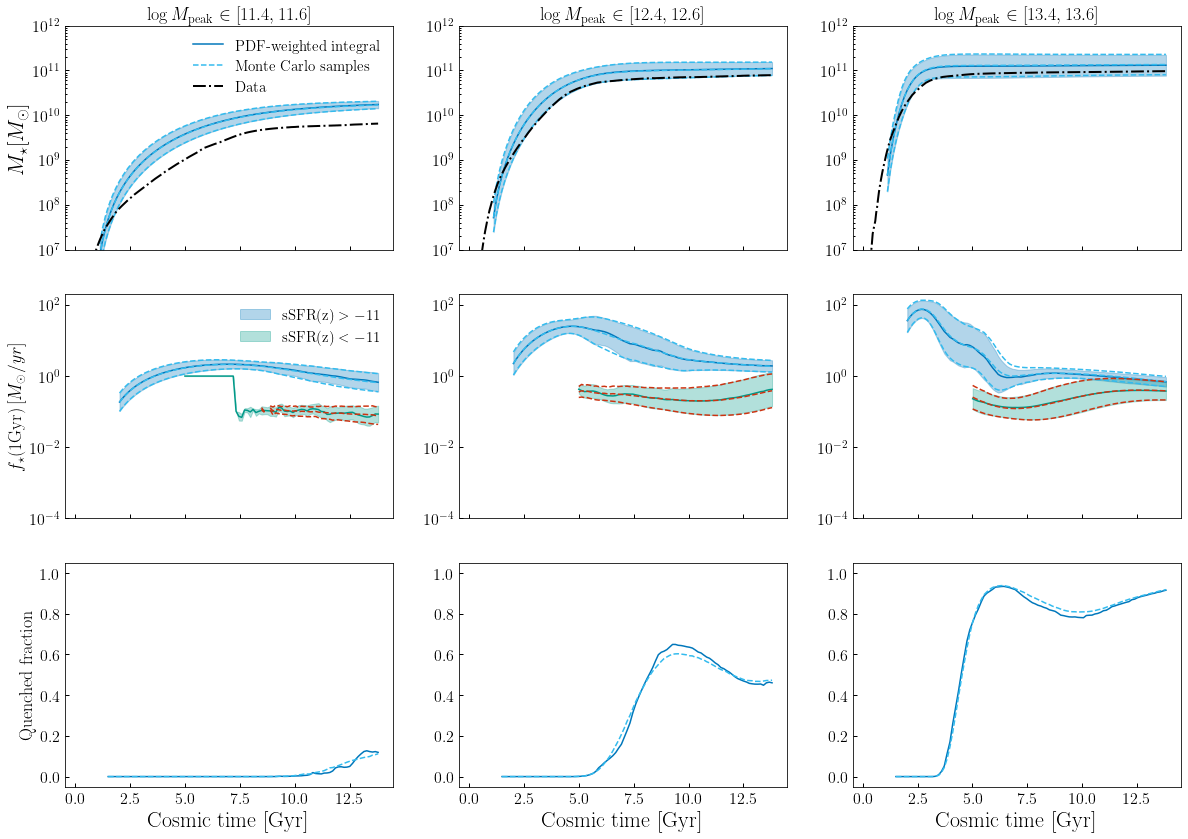

In [22]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res[0][i][sm_loss_sel], color=colors[0], label='PDF-weighted integral')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(_target_res[0][i]-np.sqrt(_target_res[1][i]))[sm_loss_sel],
                       10**(_target_res[0][i]+np.sqrt(_target_res[1][i]))[sm_loss_sel],
                       color=colors[0],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res[2][i][fstar_loss_MS_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(_target_res[2][i]-np.sqrt(_target_res[4][i]))[fstar_loss_MS_sel],
                       10**(_target_res[2][i]+np.sqrt(_target_res[4][i]))[fstar_loss_MS_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res[3][i][fstar_loss_Q_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(_target_res[3][i]-np.sqrt(_target_res[5][i]))[fstar_loss_Q_sel],
                       10**(_target_res[3][i]+np.sqrt(_target_res[5][i]))[fstar_loss_Q_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], _target_res[6][i], color=colors[0])

    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_MC_res[0][i][sm_loss_sel], ls="--", color=colors[1], label='Monte Carlo samples')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res[0][i]-np.sqrt(_MC_res[1][i]))[sm_loss_sel], ls="--", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res[0][i]+np.sqrt(_MC_res[1][i]))[sm_loss_sel], ls="--", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_MC_res[2][i][fstar_loss_MS_sel], ls="--", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res[2][i]-np.sqrt(_MC_res[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res[2][i]+np.sqrt(_MC_res[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_MC_res[3][i][fstar_loss_Q_sel], ls="--", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res[3][i]-np.sqrt(_MC_res[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res[3][i]+np.sqrt(_MC_res[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _MC_res[6][i], ls="--", color=colors[1])
    
    
    ax[0,i].plot(SMDPL_t, 10**mstar_data_Q[i], ls="-.", color='k', lw = 2, label='Data')

    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
#fig.savefig('test_mc_integration_target_from_model_fstar_validation_wrt_MonteCarlo.png', bbox_inches='tight', dpi=300)


/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


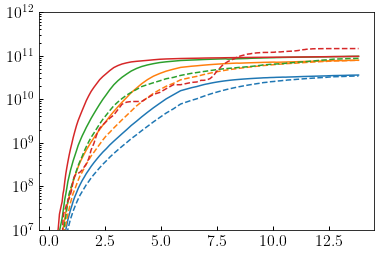

In [65]:
for i in range(4):
    line = plt.plot(SMDPL_t, 10**mstar_data_Q[i])[0]
    plt.plot(SMDPL_t, 10**mstar_data_MS[i], '--', color=line.get_color())
    
plt.ylim(1e7,1e12)
plt.yscale('log')

In [39]:
from diffstarpop.pdfmodel import UH
@jjit
def _sm_func_UH(
    lgt,
    dt,
    dmhdt,
    log_mah,
    sfr_ms_params,
    q_params,
    index_select,
    index_high,
    fstar_tdelay,
):
    sfr_params = [*sfr_ms_params[0:3], UH, sfr_ms_params[3]]
    return calculate_sm_sfr_fstar_history_from_mah(
        lgt,
        dt,
        dmhdt,
        log_mah,
        sfr_params,
        q_params,
        index_select,
        index_high,
        fstar_tdelay,
    )


_A = (None, None, 0, 0, None, None, None, None, None)
_B = (None, None, None, None, 0, 0, None, None, None)
sm_sfr_history_vmap_halos = jjit(vmap(_sm_func_UH, in_axes=_A))
sm_sfr_history_vmap = jjit(vmap(vmap(_sm_func_UH, in_axes=_A), _B))

In [40]:
from jax import lax
@jjit
def sm_sfr_history_scan(
    lgt,
    dt,
    dmhdt,
    log_mah,
    sfr_ms_params_arr,
    q_params_arr,
    index_select,
    index_high,
    fstar_tdelay,
):
    nmah = len(dmhdt)
    nsfh = len(sfr_ms_params_arr)
    nfstar = len(index_high)
    nt = len(lgt)
    
    init = (
        jnp.zeros((nmah, nt)),
        jnp.zeros((nmah, nt)),
        jnp.zeros((nmah, nfstar)),
    )
    @jjit
    def _testfun_scan(carry, data):
        sfr_ms_params, q_params = data
        _res = sm_sfr_history_vmap_halos(
            lgt,
            dt,
            dmhdt,
            log_mah,
            sfr_ms_params,
            q_params,
            index_select,
            index_high,
            fstar_tdelay,
        )
        return _res, _res
    
    data = (sfr_ms_params_arr, q_params_arr)
    result = lax.scan(_testfun_scan, init, data)
    
    return result[1] 

In [49]:
@jjit
def sm_sfr_history_scan_full(
    lgt,
    dt,
    dmhdt_arr,
    log_mah_arr,
    sfr_ms_params_arr,
    q_params_arr,
    index_select,
    index_high,
    fstar_tdelay,
):
    nmah = len(dmhdt_arr)
    nsfh = len(sfr_ms_params_arr)
    nfstar = len(index_high)
    nt = len(lgt)
    
    init1 = (
        jnp.zeros((nmah, nt)),
        jnp.zeros((nmah, nt)),
        jnp.zeros((nmah, nfstar)),
    )
    

    def _testfun_scan1(carry, data):
        sfr_ms_params, q_params = data
        
        
        def _testfun_scan2(carry2, data2):
            dmhdt, log_mah = data2
            
            _res = _sm_func_UH(
                lgt,
                dt,
                dmhdt,
                log_mah,
                sfr_ms_params,
                q_params,
                index_select,
                index_high,
                fstar_tdelay,
            )
            return _res, _res
        
        init2 = (
            jnp.zeros(nt),
            jnp.zeros(nt),
            jnp.zeros(nfstar)
        )
        
        data2 = (dmhdt_arr, log_mah_arr)
        result2 = lax.scan(_testfun_scan2, init2, data2)[1]
        
        return result2, result2
    
    data1 = (sfr_ms_params_arr, q_params_arr)
    result = lax.scan(_testfun_scan1, init1, data1)
    
    return result[1] 

In [42]:
_res_vmap = sm_sfr_history_vmap(
    jnp.log10(SMDPL_t),
    _get_dt_array(SMDPL_t),
    res_SMDPL[0][3][:10],
    res_SMDPL[0][4][:10],
    res_SMDPL[2][:5,[0,1,2,4]],
    res_SMDPL[2][:5,5:9],
    index_select_SMDPL,
    fstar_indx_high_SMDPL,
    fstar_tdelay,
)


In [53]:
_res_scan = sm_sfr_history_scan(
    jnp.log10(SMDPL_t),
    _get_dt_array(SMDPL_t),
    res_SMDPL[0][3][:10],
    res_SMDPL[0][4][:10],
    res_SMDPL[2][:5,[0,1,2,4]],
    res_SMDPL[2][:5,5:9],
    index_select_SMDPL,
    fstar_indx_high_SMDPL,
    fstar_tdelay,
)

In [54]:
_res_scan_full = sm_sfr_history_scan_full(
    jnp.log10(SMDPL_t),
    _get_dt_array(SMDPL_t),
    res_SMDPL[0][3][:10],
    res_SMDPL[0][4][:10],
    res_SMDPL[2][:5,[0,1,2,4]],
    res_SMDPL[2][:5,5:9],
    index_select_SMDPL,
    fstar_indx_high_SMDPL,
    fstar_tdelay,
)

In [55]:
_res_vmap[0].shape, _res_scan[0].shape, _res_scan_full[0].shape

((5, 10, 117), (5, 10, 117), (5, 10, 117))

In [56]:
for x,y in zip(_res_vmap, _res_scan):
    print(np.allclose(x,y, rtol=1e-3))
for x,y in zip(_res_vmap, _res_scan_full):
    print(np.allclose(x,y, rtol=1e-3))

True
True
True
True
True
True


In [112]:
_res_vmap[2][0,1] - _res_scan[2][0,1]



DeviceArray([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00, -2.9802322e-08, -2.9802322e-08,
             -2.9802322e-08, -4.4703484e-08, -2.9802322e-08,
             -1.4901161e-08,  0.0000000e+00, -2.7939677e-08,
             -2.7474016e-08, -2.7706847e-08,  4.4237822e-09,
              6.3970219e-08,  3.2014214e-08,  3.1985110e-08,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e

In [ ]:
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    init_params

In [65]:
res_SMDPL[2][:5,[0,1,2,4]][0]

array([12.3787  ,  2.78867 ,  0.874736,  0.973339])

In [64]:
res_SMDPL[2][:5,:5][1]

array([10.8306  ,  0.841903,  2.16245 , -0.767132, 16.1442  ])